# Model Reference/ Model Identification Adaptive Control (MRAC/MIAC)

(also called Self-Tuning Controllers (STC))

The network structure for Model Reference Adaptive Control is very similar to the structure for a Generative Adversarial Model.  In some ways, MRAC is the control equivalent of a GAN, although unlike GAN's MRAC models are not applied to categorical data.

The purpose of MRAC is to control a plant $x = P(u)$, where $u$ is a vector of control inputs, and $x$ is the state that results from those control inputs.  There is a desired state $x^*$, and the goal is to find the control inputs $u=K(x^*)$ such that $x = P(u) = P(K(x^*)) \approx x^*$.  To save parentheses, this is sometimes written $PKx^* \approx x^*$, which shows the sense in which $K$ behaves like an inverse to the plant $P$.  We thus call $K$ an "inverse model" of the plant.  

It is also possible to create a "forward model" of the plant, which is a network $\hat{P}$ that tries to approximate the true plant using $\hat{x} = \hat{P}(u)$.  In MRAC, we use a forward model to train the inverse model.  The value of doing this is that we know the structure of the forward model, which allows us to find the approximate derivative
\begin{equation}
  \frac{dx}{du} \approx \hat{P}'(u)
\end{equation}
The reason this is important is that to train the weights $w_K$ of the inverse model we need to know how those weights affect the state $x$, so we need to know $dx/dw_K$.  But normally we don't know this because we have no information about the plant.  But if we have a forward model, then we can derive:
\begin{equation}
  \frac{dx}{dw_K} = \frac{dx}{du}\cdot \frac{du}{dw_K}
\end{equation}
and we can find $du/dw_K$ by backpropagation through the network $K(x^*)$.  

Interestingly, the forward model does not have to be that good.  To give a concrete example of this, we might want to increase the value of the state $x$, but we don't know whether increasing or decreasing $u$ will achieve this.  But if we know the *sign* of $dw/du$ then we know which way to adjust $u$, and if we adjust slowly enough we will be reducing the error.  So even a very poor forward model can sometimes train a very accurate inverse model.

Usually there are only a few desired states $x^*$ that we care about.  They may lie along a particular trajectory, or in a particular region of space, or far from areas of danger.  This makes learning $K$ easier, because we don't need to train it for all possible inputs.  

The problem is that we need to be careful to train $\hat{P}$ everywhere that a needed control input occurs, and we don't know where that is.  One option is the apparently random movements made by babies: supply random noise as inputs $u$ and see what values of $x=P(u)$ result, then train $\hat{P}$ on the dataset $\{ (u,x) \}$.  This can be inefficient in high dimensional spaces, and more importantly it can be dangerous if you are not a small and well-padded baby.

The other way to do this is to use the outputs of the inverse model $u=K(x^*)$ as the inputs for training $\hat{P}$.  This is a problem while the inverse model is still learning, because those outputs may cause problems or be dangerous.  It is also a problem because if $K$ never generates control commands in some region of space, then $\hat{P}$ will never learn about the region of space, and the entire network gets stuck in a local minimum, just as we saw with the GAN networks.

One solution to this problem is Kawato's "Feedback Error Learning" (FEL) which uses a very simple feedback controller to train the more complicated inverse model.  In a sense, rather than using a forward model to train the inverse model, FEL uses a simple inverse model to train a more complex inverse model.  In FEL, you first create a feedback controller $u_{fb} = k(x^*-x)$ where here $k$ is just a number (or a matrix) that provides a gain on the error $x^*-x$. In fact, so long as the sign of $k$ is correct and $k$ is not so large that the system becomes unstable, this will work.  For any real dynamic system, such a feedback controller will have poor performance with overshoot and oscillations.  

But the key to FEL is that you use the feedback signal as an error signal to train a better inverse model.  In this case, the idea is to combine the inverse model with the feedback signal so that $u = K(x^*) + k(x^*-x)$.  If $K(x^*)$ was perfect, then $PKx^* = x^*$ and the feedback error $u_{fb} = k(x^*-x)=0$.  The feedback error $u_{fb}$ functions like a teaching signal for the network $K$.  The better the student, the less the teacher has to correct, until finally the system can run almost without the feedback.  




In [215]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from keras import layers
import time
import math as m

import tensorflow as tf
from scipy import signal

from numpy.random import default_rng
from numpy import linalg as LA


#for your homework
np.random.seed(10327798)
tf.random.set_seed(10327798)

#MRAC/STC vs. GAN

In MRAC, the inverse_model and forward_model are the equivalent to the GAN generator and discriminator networks.

Both networks have examples of "real" data, but in MRAC the real data is a set of input/output pairs for the real world plant. Technically GANs also have input/output pairs, but since they are trained only with positive examples, the real data consists of inputs whose outputs are always 1.  Also note that in an GAN the original input to the network (the equivalent of the desired trajectory $x^*$ is random.

##The Plan model

In [216]:
#create the artificial plant
#this is a simple 2D robot arm where you set the joint position of shoulder and elbow and it outputs the x,y position of the hand
def Real_Plant(dat):
  #dat is a tensor; this is important because this function will be called within a tensorflow gradientTape block
  joint1 = dat[:,0]
  joint2 = dat[:,1]
    #joint1 and joint2 are 0..1 which is converted to 0..pi/2
  link1 = 100.0  #link lengths in cm
  link2 = 80.0
  #convert the 0..1 range inputs to joint angles
  pi = tf.constant(m.pi)    #note that we cannot use np.pi and many other numpy functions because tensorflow will choke
  th1 = joint1 * pi/2.0
  th2 = joint2 * pi/2.0
  #convert joint angles to endpoint positions for the robot
  x = link1 * tf.cos(th1) + link2 * tf.cos(th1+th2)   #have to use tf equivalents of the np functions for gradientTape
  y = link1 * tf.sin(th1) + link2 * tf.sin(th1+th2)
  #convert output to be 0..1
  x /= (link1 + link2)    #divide by max extent in each dimension
  y /= (link1 + link2)
  #output can be outside the range 0..1 for some inputs
  return tf.stack([x,y], axis=1)   #this is the tf equivalent to np.horizontal_stack()

##  Forward model

Straightforward 4 layer network. Sandwiching a relu layer allows more variable outputs, but sigmoids on the input and output because this is continuous data.

In [217]:
def make_forward_model(n_inputs):
    model = tf.keras.Sequential()
    model.add(layers.Dense(40, batch_input_shape=(None, n_inputs), activation='sigmoid'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(40, activation='sigmoid'))
    model.add(layers.Dense(n_inputs))  

    return model

##Inverse model

Note that I put a sigmoid nonlinearity on the output.  This is because the input to the plant (the joint angles) is artifically set to be between 0..1.  I want to make sure the network will not go too far outside these bounds and make things spin.

In [218]:
def make_inverse_model(n_inputs):
    model = tf.keras.Sequential()
    model.add(layers.Dense(40, batch_input_shape=(None,n_inputs), activation='sigmoid'))
    model.add(layers.Dense(40, activation='relu'))
    model.add(layers.Dense(40, activation='sigmoid'))
    model.add(layers.Dense(n_inputs, activation='sigmoid'))

    return model

##Noise Model

One purpose to adding noise during training is to enforce "Persistence of Excitation".  Accurate training of the forward model depends upon exploring the space of inputs and states as much as possible.  Adding noise can help do that, even when the inverse model only produces a limited set of outputs.

In [219]:
def make_noise_layer(n_inputs):
  model = tf.keras.Sequential()
  model.add(layers.Input(shape = (n_inputs,)))
  model.add(layers.GaussianNoise(0.2))
  return model

In [220]:
#now, make the models using the functions we just created
nInputs = 2
forward_model = make_forward_model(nInputs)
inverse_model = make_inverse_model(nInputs)
noise_model = make_noise_layer(nInputs)

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [221]:
# This method returns a helper function to compute cross entropy loss
#  It creates a function cross_entropy(y_true, y_predicted)
#  when logits=True is set, y_predicted is in -\infty .. \infty, otherwise in 0..1
#  y_true is always in 0..1
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#except that unlike for GANs, we will use mean-squared error since MRAC uses continuous functions and data.
mse = tf.keras.losses.MeanSquaredError()

### Forward Model loss

The forward model is trying to predict the output of the plant from the input to the plant.  So the loss is the mse between the real output and the predicted output.

In [222]:
def forward_loss(real_output, predicted_output):
    return mse(real_output, predicted_output)

### Inverse Model loss
The inverse model is trying to get the output of the plan closer to the desired output $x^*$.   So the loss is the mse between the desired output and the actual output.

In [223]:
def inverse_loss(desired_output, predicted_output):
    return mse(desired_output, predicted_output)

The inverse and forward optimizers are different since you will train two networks separately.

In [224]:
inverse_optimizer = tf.keras.optimizers.Adam(1e-3)
forward_optimizer = tf.keras.optimizers.Adam(1e-3)

## Define the training loop


In [225]:
BATCH_SIZE = 20

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(dataBatch):

    #run the forward training outside the gradientTape so the gradients of the true plant are not known
    plant_input = inverse_model(dataBatch)
    plant_input = noise_model(plant_input)
    real_output = Real_Plant(plant_input)  #because this is inside a @tf.function decoration, you cannot use most numpy() functions

    with tf.GradientTape() as inv_tape, tf.GradientTape() as for_tape:   #tapes will watch all the trainable variables
      plant_input = inverse_model(dataBatch, training=True)
      plant_input = noise_model(plant_input)
      predicted_output = forward_model(plant_input, training=True)
      
      for_loss = forward_loss(real_output, predicted_output)  
      inv_loss = inverse_loss(dataBatch, predicted_output)  #dataBatch is the desired_output
        #if you try inverse_loss(dataBatch, real_output) it will fail because cannot calculate the gradients

    gradients_of_inverse = inv_tape.gradient(inv_loss, inverse_model.trainable_variables)  #find the gradients based on the relative changes in the variables
    gradients_of_forward = for_tape.gradient(for_loss, forward_model.trainable_variables)

    inverse_optimizer.apply_gradients(zip(gradients_of_inverse, inverse_model.trainable_variables))  #gradient descent on the weights
    forward_optimizer.apply_gradients(zip(gradients_of_forward, forward_model.trainable_variables))

In [226]:
#This is the actual training step.  Each epoch generates a series of batches.
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for iData in range(len(dataset)):
      data_batch = dataset[iData:iData+BATCH_SIZE,:]  #batches are overlapping
      train_step(data_batch)   #train one mini-batch

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  

## Train the model
Call the `train()` method defined above to train the inverse and forward models simultaneously. 


First step is to generate the "true" dataset.  In this case the goal is to make a small circle with the hand at the end of the robot arm.  So this looks like cosine in the x direction and sin in the y direction.

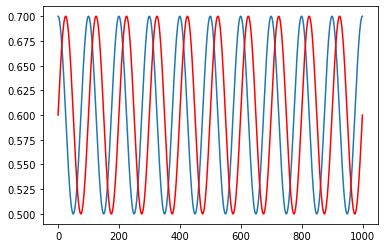

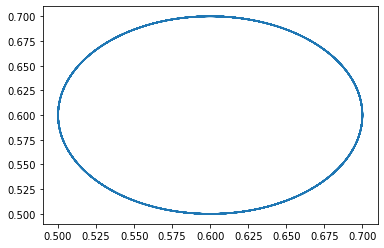

In [227]:
maxTime = 10  #seconds
nTimePoints = 1000
t = np.linspace(0,maxTime,nTimePoints)
#desired trajectory is a set of small circles in the middle of the workspace
x = 0.6 + 0.1 * np.cos(2.0*np.pi*t)
y = 0.6 + 0.1 * np.sin(2.0*np.pi*t)
desired_output = np.column_stack((x,y))
plt.figure()
plt.plot(desired_output[:,0]);
plt.plot(desired_output[:,1],'r');
plt.figure()
plt.plot(desired_output[:,0],desired_output[:,1]);

In [228]:
def show_results():
  plant_input = inverse_model(desired_output)
  predicted_output = forward_model(plant_input)
  real_output = Real_Plant(plant_input)
  plt.figure(figsize=(9,3))
  plt.plot(t,predicted_output,'b')
  plt.title('predicted output')
  plt.figure(figsize=(9,3))
  plt.plot(t,real_output,'r')
  plt.title('real output')
  plt.figure(figsize=(9,3))
  plt.plot(t,desired_output,'k')
  plt.title('desired output')
  plt.figure(figsize=(9,3))
  plt.plot(t,plant_input)
  plt.title('control inputs')
  plt.figure(figsize=(3,3))
  plt.plot(real_output[:,0], real_output[:,1], 'r')
  plt.title('real output')

## Here is where the training actually happens

It is much harder to use the desired_output as the training data, because this is usually  not a very rich dataset for training.  So in this case we will use random white noise.  That is partially cheating, because it means you get to try everything safely, and you don't care what you bump into along the way.  That's fine for babies, it is less cute when learning to drive.  Nevertheless training on the desired trajectory tends to be slower, and in fact the right answer is to gradually change the desired trajectory to make it more and more complicated while maintaining safety.

In [229]:
rng = default_rng()

#One tricky issue is that you cannot create new variables within the @tf.function "decorator".  
#  therefore we will pre-create these variables so that tf.function can reuse them.
data_batch = desired_output[0:BATCH_SIZE,:]
random_batch = rng.random(data_batch.shape)
plant_input = inverse_model(random_batch)
predicted_output = forward_model(plant_input)
real_output = Real_Plant(plant_input)

#this will be used for training
random_dataset = rng.random(desired_output.shape)

  

Time for epoch 1 is 9.467074871063232 sec
Time for epoch 2 is 1.2760956287384033 sec
Time for epoch 3 is 1.2439115047454834 sec
Time for epoch 4 is 1.2658390998840332 sec
Time for epoch 5 is 1.2291755676269531 sec
Time for epoch 6 is 1.2400941848754883 sec
Time for epoch 7 is 1.2621934413909912 sec
Time for epoch 8 is 1.256237506866455 sec
Time for epoch 9 is 1.2587318420410156 sec
Time for epoch 10 is 1.2504889965057373 sec
Time for epoch 11 is 1.2407810688018799 sec
Time for epoch 12 is 1.231482744216919 sec
Time for epoch 13 is 1.2452421188354492 sec
Time for epoch 14 is 1.2121613025665283 sec
Time for epoch 15 is 1.293031930923462 sec
Time for epoch 16 is 1.2328269481658936 sec
Time for epoch 17 is 1.2340693473815918 sec
Time for epoch 18 is 1.2402617931365967 sec
Time for epoch 19 is 1.2345168590545654 sec
Time for epoch 20 is 1.2424538135528564 sec
Time for epoch 21 is 1.2302207946777344 sec
Time for epoch 22 is 1.2416069507598877 sec
Time for epoch 23 is 1.2504265308380127 sec
T

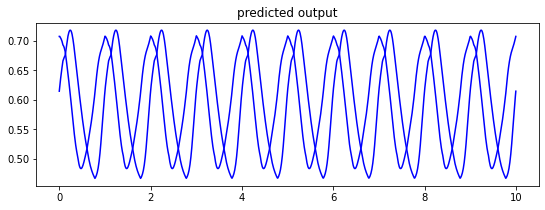

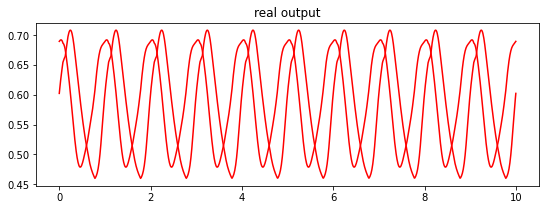

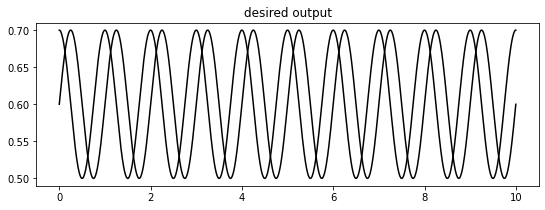

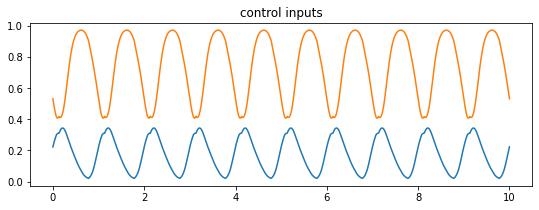

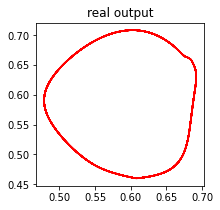

In [230]:
#can choose your training type
random_training = True
if random_training:
  train(random_dataset, epochs=25)
else:
  train(desired_output,epochs=25)
show_results();

#Training method2

Another way to train this type of network is by direct inversion of the plant.  This is not technically MRAC, but it is worth seeing for comparison.  Once you have issued a command $u$ and seen the new state $x=P(u)$, there is nothing to stop you from training $K$ with input $x$ and output $u$.  This is directly learning the inverse to the plant $P$.  The problem is the same one we face all along:  until you have a successful example of performance, there is no guarantee you will ever find a solution.  For example, suppose you are trying to learn a triple-backflip off a high-dive board, but every time you try you do a belly-flop.  While this provides plenty of training data for the subsequent belly-flop competition, you never experience useful training for the triple back-flip.  

In [231]:
def train2(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    random_batch = rng.random(dataset.shape)
    plant_input = inverse_model(random_batch)
    plant_input = noise_model(plant_input)
    real_output = Real_Plant(plant_input)

    forward_model.fit(plant_input, real_output, batch_size = 20, epochs=2, verbose=0)
    predicted_output = forward_model(plant_input)
    #can train on either the real_output or predicted_output
    inverse_model.fit(real_output, plant_input, batch_size = 20, epochs=2, verbose=0)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  

Time for epoch 1 is 1.2285912036895752 sec
Time for epoch 2 is 0.6978878974914551 sec
Time for epoch 3 is 0.3753783702850342 sec
Time for epoch 4 is 0.39549875259399414 sec
Time for epoch 5 is 0.38938260078430176 sec
Time for epoch 6 is 0.39637088775634766 sec
Time for epoch 7 is 0.38080406188964844 sec
Time for epoch 8 is 0.38606882095336914 sec
Time for epoch 9 is 0.5537354946136475 sec
Time for epoch 10 is 0.37271833419799805 sec
Time for epoch 11 is 0.3931007385253906 sec
Time for epoch 12 is 0.5358736515045166 sec
Time for epoch 13 is 0.389782190322876 sec
Time for epoch 14 is 0.5392656326293945 sec
Time for epoch 15 is 0.6774017810821533 sec
Time for epoch 16 is 0.8601701259613037 sec
Time for epoch 17 is 0.9032995700836182 sec
Time for epoch 18 is 1.080378532409668 sec
Time for epoch 19 is 0.38146042823791504 sec
Time for epoch 20 is 0.5395214557647705 sec
Time for epoch 21 is 0.5308842658996582 sec
Time for epoch 22 is 0.3768901824951172 sec
Time for epoch 23 is 0.3861632347106

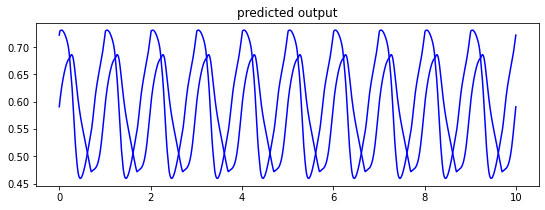

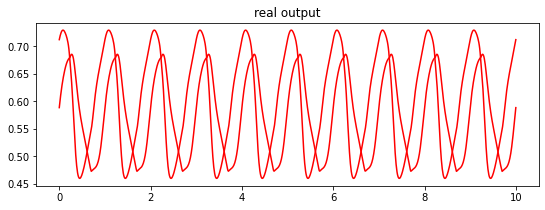

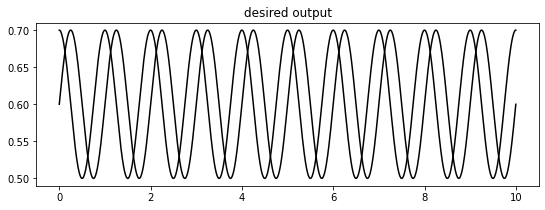

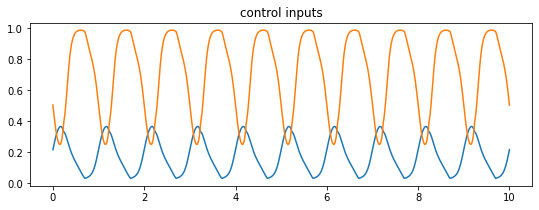

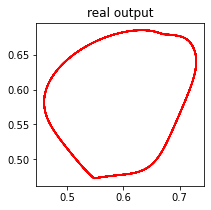

In [232]:
forward_model.compile(optimizer='adam', loss='mse')
inverse_model.compile(optimizer='adam', loss='mse')
train2(desired_output, epochs=25)
show_results()